In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob
from tqdm import tqdm
import io, sys, os

import pygamma
import gsw

from dask.distributed import Client
import dask
import cmocean

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42161,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:40903,Total threads: 1
Dashboard: /proxy/44359/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44503,


## Load data and compute SA etc:

In [3]:
# 1-degree RYF:
sim = '1deg_jra55v14_ryf'
base = '/g/data/ik11/outputs/access-om2/' + sim + '/'
output = '099'
tmp_dir = '/g/data/e14/rmh561/McDougall_tmp'

In [4]:
os.chdir('/home/561/rmh561/access-om2-analysis/cosima-scripts/McDougall_Sa')

In [5]:
# Preformed salinity (model salinity variable):
Sstar = xr.open_dataset(base + 'output' + output + '/ocean/ocean-3d-salt-1-monthly-mean-ym_1999_01.nc').mean('time').salt.load()
CT = xr.open_dataset(base + 'output' + output + '/ocean/ocean-3d-temp-1-monthly-mean-ym_1999_01.nc').mean('time').temp.load()

# Depth, lon, lat, pressure:
dzt = xr.open_dataset(base + 'output' + output + '/ocean/ocean-3d-dzt-1-monthly-mean-ym_1999_01.nc').mean('time').dzt.load()
z = -dzt.cumsum('st_ocean')
z[1:,:,:] = (z[1:,:,:].values + z[:-1,:,:].values)/2.
z[0,:,:] = z[0,:,:]/2.
lat = xr.open_dataset(base + 'output' + output + '/ocean/ocean-2d-geolat_t.nc').mean('time').geolat_t
lon = xr.open_dataset(base + 'output' + output + '/ocean/ocean-2d-geolon_t.nc').mean('time').geolon_t
p = gsw.p_from_z(z,lat)
p_no_nan = p.fillna(0.)+p.st_ocean/1e8
f = (2*(2*np.pi/86400)*np.sin(2*np.pi*lat/360.))

# Absolute Salinity:
SA = gsw.SA_from_Sstar(Sstar,p,lon,lat)

# Put it all in a dataset:
ds = CT.rename('CT').to_dataset()
ds['CT'] -= 273.15 # Convert to Kelvin
ds['Sstar'] = Sstar
ds['SA'] = SA
ds['p'] = p_no_nan
ds['lat'] = lat
ds['lon'] = lon
ds['f'] = f

In [38]:
# Compute approximate streamfunction from model zonal velocity
U = xr.open_dataset(base + 'output' + output + '/ocean/ocean-3d-u-1-monthly-mean-ym_1999_01.nc').mean('time').u.load()
dyu = xr.open_dataset(base + 'output' + output + '/ocean/ocean-2d-dyu.nc').dyu.load()
dzu = xr.zeros_like(U).copy(deep=True)
dzu[:,:-1,:-1] = (dzt[:,:-1,:-1].values+dzt[:,1:,:-1].values+dzt[:,:-1,1:].values+dzt[:,1:,1:].values)/4.

tx_trans_approx = U*dyu*dzu
psi_approx = tx_trans_approx[:,::-1,:].cumsum('yu_ocean')[:,::-1,:]
psi_approx = psi_approx.where(~np.isnan(tx_trans_approx))

In [89]:
# Subsample to the North Pacific for testing:
ds = ds.sel(xt_ocean=slice(-260.,-100.),yt_ocean=slice(20.,65.))

## Compute PISH using matlab:

In [31]:
# Save to file for input into matlab function:
ds.to_netcdf(tmp_dir + '/' + sim + '_output' + output + '_SA_CT_p_global.nc')

# Use matlab to create PISH:
# qsub call_matlab

In [6]:
# Read back into python:
PISH_SA = xr.open_dataset(tmp_dir + '/' + sim + '_output' + output + '_PISH_SA_global.nc')['PISH_SA']
PISH_Sstar = xr.open_dataset(tmp_dir + '/' + sim + '_output' + output + '_PISH_Sstar_global.nc')['PISH_Sstar']

# Add coordinates back in:
PISH_SA = PISH_SA.assign_coords({'xt_ocean':ds.xt_ocean,'yt_ocean':ds.yt_ocean})
PISH_Sstar = PISH_Sstar.assign_coords({'xt_ocean':ds.xt_ocean,'yt_ocean':ds.yt_ocean})

In [91]:
# Compute streamfunction from PISH:
g = 9.7963
rho0 = 1035.
Psi_SA = (PISH_SA)/rho0/ds.f/1.e6
Psi_Sstar = (PISH_Sstar)/rho0/ds.f/1.e6

# This manipulation comes from TEOS-10 manual section 3.31. 
# k x Grad PsiISH = g^-1 f \int_P0^P1 [v(p) - v1] dP (3.31.5)
# so, as noted below the equation, using the hydrostatic relationship dP = rho*g*dz, with rho=rho0, to convert the pressure integral to a depth integral, the mass streamfunction in units of m3s-1 is
# k x Grad Psi = \int_z^z0 [v(z) - v0] dz = (k x Grad PsiISH) * g / f / (rho0 * g) = (k x Grad PsiISH) / rho0 / f
# I.e. consistent with "PISH should be quoted in units of so that its two-dimensional gradient has the same units as the depth-integrated flux of times the Coriolis frequency."

# Subtract off a single point (only gradients matter):
Psi_SA = Psi_SA - Psi_SA.sel(xt_ocean=-200.,yt_ocean=20.,method='nearest')
Psi_Sstar = Psi_Sstar - Psi_Sstar.sel(xt_ocean=-200.,yt_ocean=20.,method='nearest')
#PISH_SA = PISH_SA - PISH_SA.sel(xt_ocean=-200.,yt_ocean=20.,method='nearest')
#PISH_Sstar = PISH_Sstar - PISH_Sstar.sel(xt_ocean=-200.,yt_ocean=20.,method='nearest')

## Do some plotting:

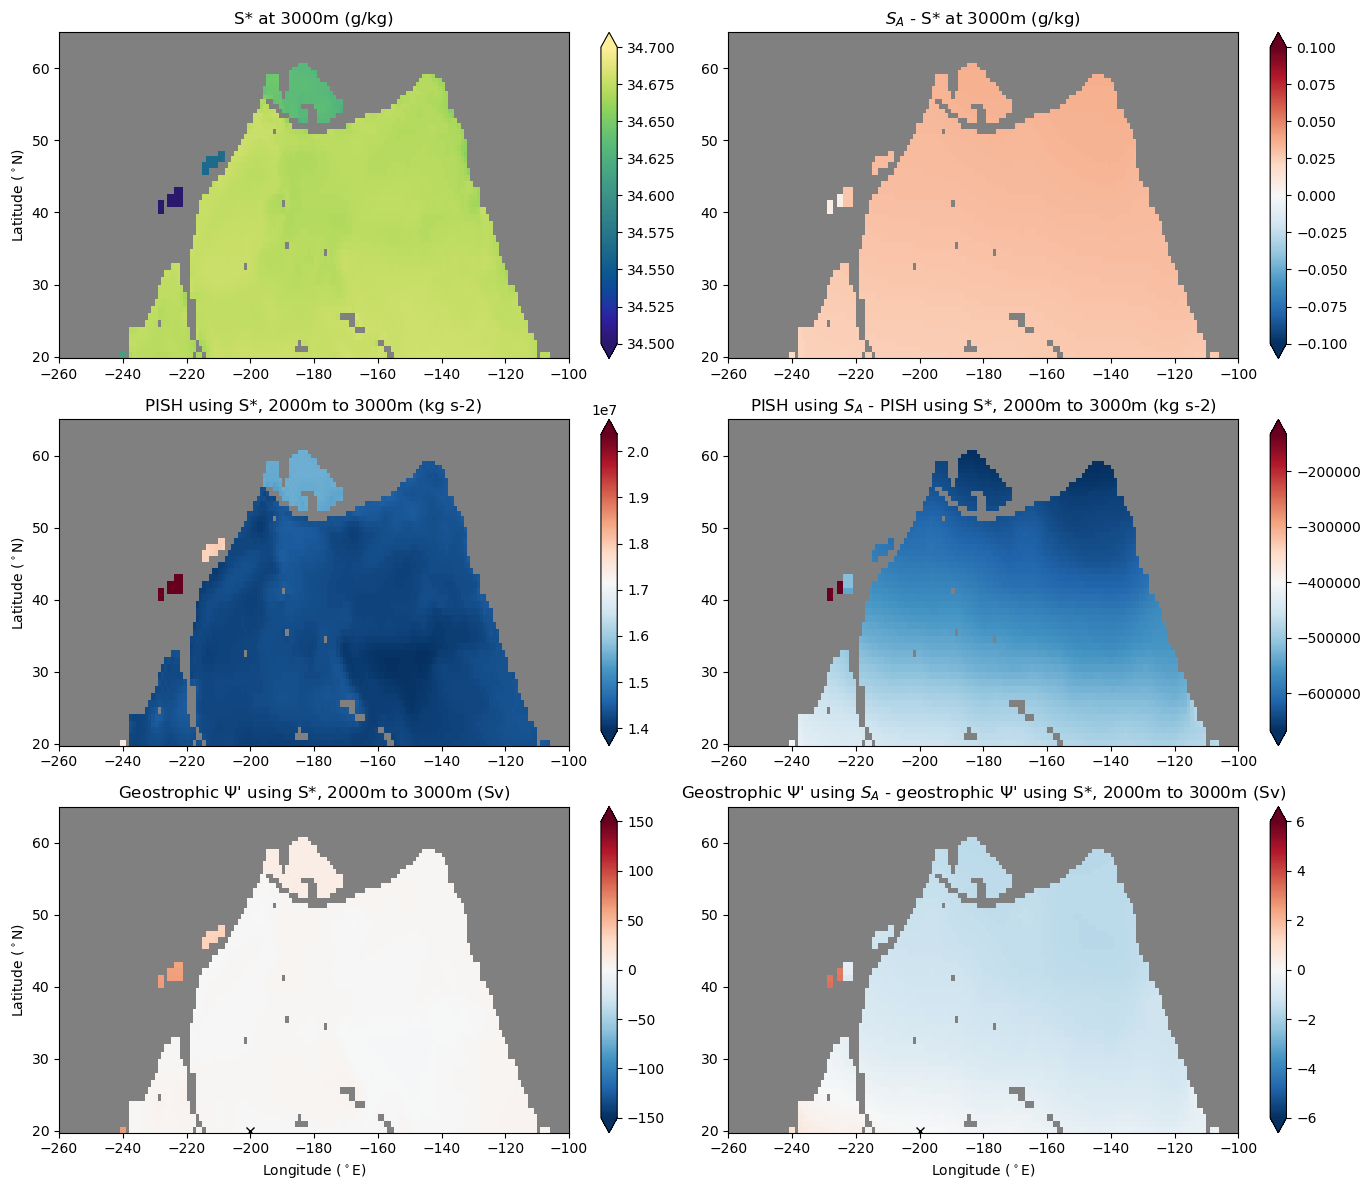

In [74]:
depth0 = 2000.
depth = 3000.

# Subtract off values at depth0:
PISH_Sstar_dif = PISH_Sstar - PISH_Sstar.sel(st_ocean=depth0)
PISH_SA_dif = PISH_SA - PISH_SA.sel(st_ocean=depth0)
Psi_Sstar_dif = Psi_Sstar - Psi_Sstar.sel(st_ocean=depth0)
Psi_SA_dif = Psi_SA - Psi_SA.sel(st_ocean=depth0)

fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(14,12))
ds['Sstar'].sel(st_ocean=depth,method='nearest').plot(ax=axes[0][0],vmin=34.5,vmax=34.7,extend='both',cmap=cm.cm.haline,cbar_kwargs={'label':''})
axes[0][0].set_title('S* at %04dm (g/kg)' % depth)
(ds['SA']-ds['Sstar']).sel(st_ocean=depth,method='nearest').plot(ax=axes[0][1],vmin=-0.1,vmax=0.1,extend='both',cmap='RdBu_r',cbar_kwargs={'label':''})
axes[0][1].set_title('$S_A$ - S* at %04dm (g/kg)' % depth)

PISH_Sstar_dif.sel(st_ocean=depth).plot(ax=axes[1][0],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''})
axes[1][0].set_title('PISH using S*, %04dm to %04dm (kg s-2)' % (depth0,depth))
(PISH_SA_dif-PISH_Sstar_dif).sel(st_ocean=depth).plot(ax=axes[1][1],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''})
axes[1][1].set_title('PISH using $S_A$ - PISH using S*, %04dm to %04dm (kg s-2)' % (depth0,depth))

Psi_Sstar_dif.sel(st_ocean=depth).plot(ax=axes[2][0],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-150.,vmax=150.)
axes[2][0].set_title('Geostrophic $\Psi$\' using S*, %04dm to %04dm (Sv)' % (depth0,depth))
axes[2][0].plot([-200.],[20.],'xk')
(Psi_SA_dif-Psi_Sstar_dif).sel(st_ocean=depth).plot(ax=axes[2][1],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-6,vmax=6)
axes[2][1].set_title('Geostrophic $\Psi$\' using $S_A$ - geostrophic $\Psi$\' using S*, %04dm to %04dm (Sv)' % (depth0,depth))
axes[2][1].plot([-200.],[20.],'xk')

axs = axes.reshape(-1)
for ax in axs:
    ax.set_facecolor([0.5, 0.5, 0.5])
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[2][0].set_xlabel('Longitude ($^\circ$E)')
axes[2][1].set_xlabel('Longitude ($^\circ$E)')
for ax in [axes[0][0],axes[1][0],axes[2][0]]:
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.tight_layout()
    
#plt.savefig('McDougall_SAvsStar_GeostrophicPsi_' + sim + '_%04dm_relative_to_%04dm_nozero.png' % (depth,depth0),bbox_inches='tight')

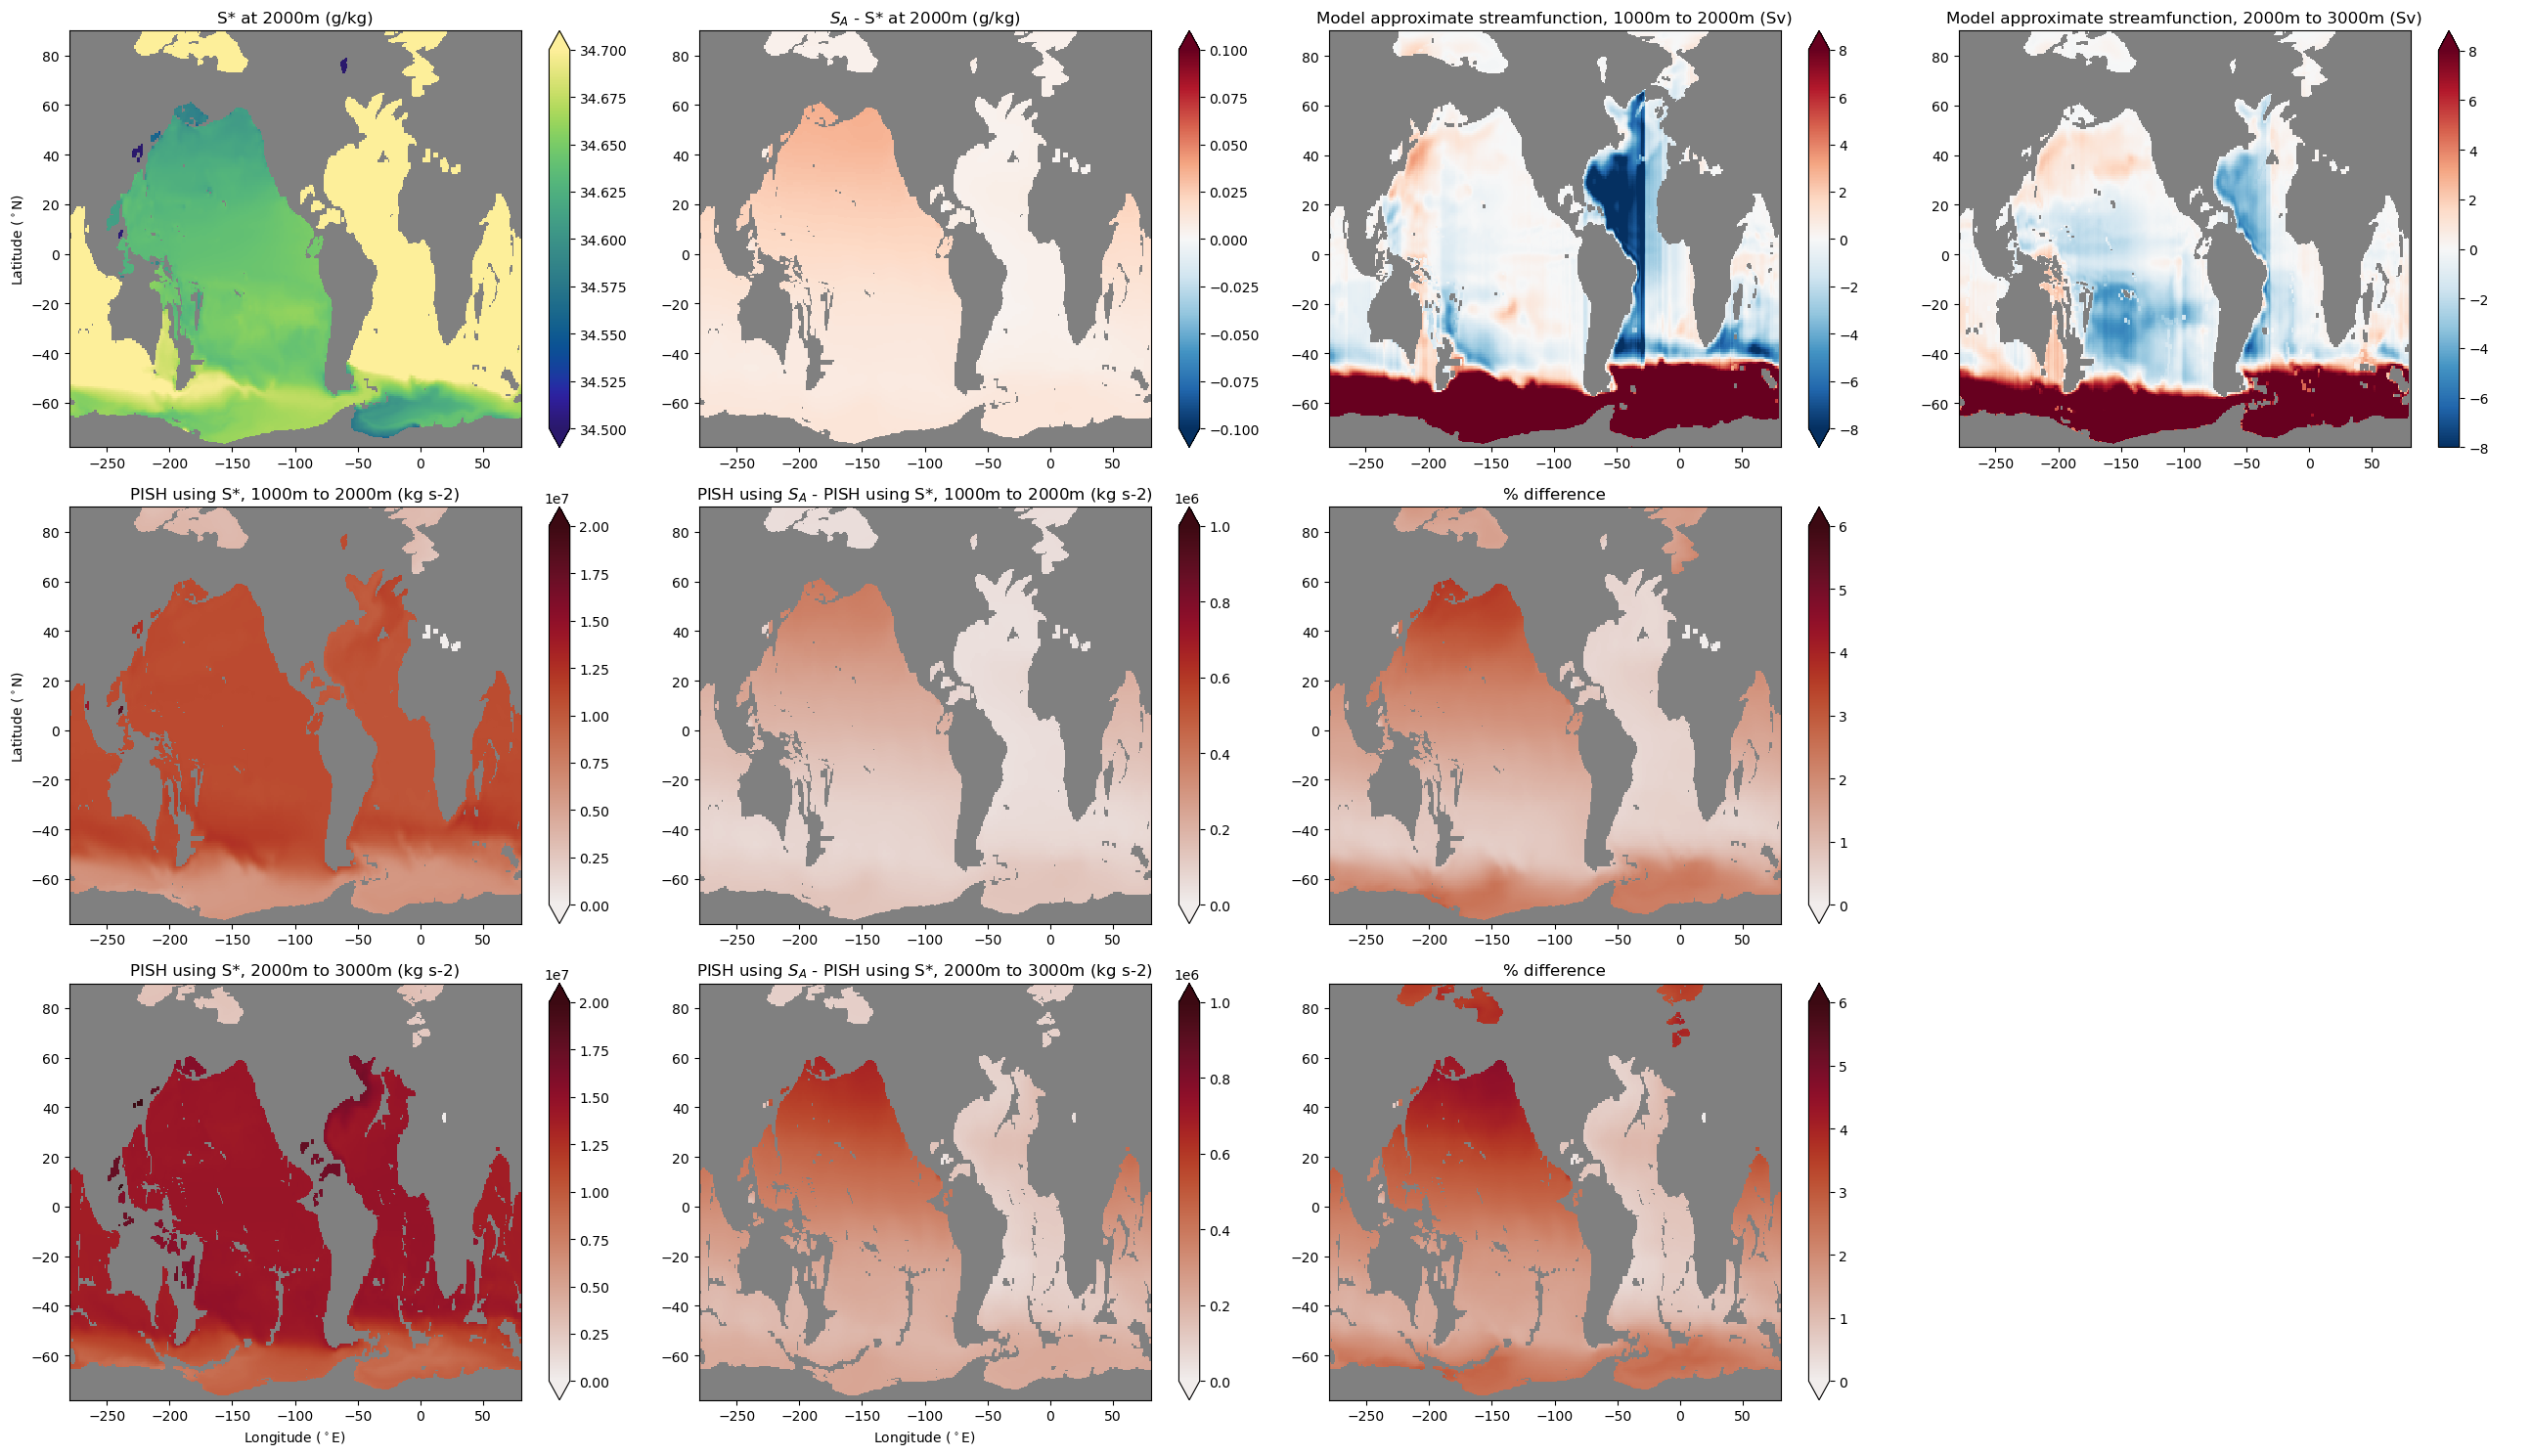

In [46]:
# More production plot:
depths = [[1000.,2000.],[2000.,3000.]]#,[3000.,4000.]]

fig, axes = plt.subplots(nrows=3,ncols=4,figsize=(26,15))

# varss = [Psi_Sstar,Psi_SA]
# label = 'Geostrophic $\Psi$\''
# tclims = [100.,250.,400.]
# aclims = [0.5,2.5,8.]

varss = [PISH_Sstar,PISH_SA]
tclims = [2e7,2e7]
aclims = [1e6,1e6]
pc_dif = 6
# tclims = [1e6,1e6]
# aclims = [2e5,2e5]
# pc_dif = 100
label = 'PISH'
unit = 'kg s-2'

depth = 2000.
ds['Sstar'].sel(st_ocean=depth,method='nearest').plot(ax=axes[0][0],vmin=34.5,vmax=34.7,extend='both',cmap=cm.cm.haline,cbar_kwargs={'label':''})
axes[0][0].set_title('S* at %04dm (g/kg)' % depth)
(ds['SA']-ds['Sstar']).sel(st_ocean=depth,method='nearest').plot(ax=axes[0][1],vmin=-0.1,vmax=0.1,extend='both',cmap='RdBu_r',cbar_kwargs={'label':''})
axes[0][1].set_title('$S_A$ - S* at %04dm (g/kg)' % depth)

depth = 2000.
depth0 = 1000.
psi_summed = (psi_approx/1.e6).sel(st_ocean=slice(depth0,depth)).sum('st_ocean')
psi_summed = psi_summed.where(psi_summed != 0.0)
psi_summed.plot(ax=axes[0][2],cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-8,vmax=8.)
axes[0][2].set_title('Model approximate streamfunction, %04dm to %04dm (Sv)' % (depth0,depth))

depth = 3000.
depth0 = 2000.
psi_summed = (psi_approx/1.e6).sel(st_ocean=slice(depth0,depth)).sum('st_ocean')
psi_summed = psi_summed.where(psi_summed != 0.0)
psi_summed.plot(ax=axes[0][3],cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-8,vmax=8.)
axes[0][3].set_title('Model approximate streamfunction, %04dm to %04dm (Sv)' % (depth0,depth))


i_adj = 1
for i, depthsb in enumerate(depths):
    depth0, depth = depthsb
    (varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0)).plot(ax=axes[i_adj+i][0],extend='both',cmap=cm.cm.amp,cbar_kwargs={'label':''},vmin=0,vmax=tclims[i])
    axes[i_adj+i][0].set_title(label + ' using S*, %04dm to %04dm ' % (depth0,depth) + '(' + unit + ')')
    #axes[i_adj+i][0].plot([-200.],[20.],'xk')
    ((varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))-(varss[1].sel(st_ocean=depth)-varss[1].sel(st_ocean=depth0))).plot(ax=axes[i_adj+i][1],extend='both',cmap=cm.cm.amp,cbar_kwargs={'label':''},vmin=0,vmax=aclims[i])
    axes[i_adj+i][1].set_title(label + ' using $S_A$ - ' + label + ' using S*, %04dm to %04dm ' % (depth0,depth) + '(' + unit + ')')
    #axes[i_adj+i][1].plot([-200.],[20.],'xk')
    (((varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))-(varss[1].sel(st_ocean=depth)-varss[1].sel(st_ocean=depth0)))/(varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))*100).plot(ax=axes[i_adj+i][2],extend='both',cmap=cm.cm.amp,cbar_kwargs={'label':''},vmin=0,vmax=pc_dif)
    axes[i_adj+i][2].set_title('% difference')
    #axes[i_adj+i][2].plot([-200.],[20.],'xk')

axs = axes.reshape(-1)
for ax in axs:
    ax.set_facecolor([0.5, 0.5, 0.5])
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[-1][0].set_xlabel('Longitude ($^\circ$E)')
axes[-1][1].set_xlabel('Longitude ($^\circ$E)')
for ax in [axes[0][0],axes[1][0]]:
    ax.set_ylabel('Latitude ($^\circ$N)')
axes[1][3].axis('off')
axes[2][3].axis('off')
plt.tight_layout()
plt.savefig('McDougall_SAvsStar_PISH_' + sim + '_1000to2000_and_2000to3000_global.png',bbox_inches='tight')

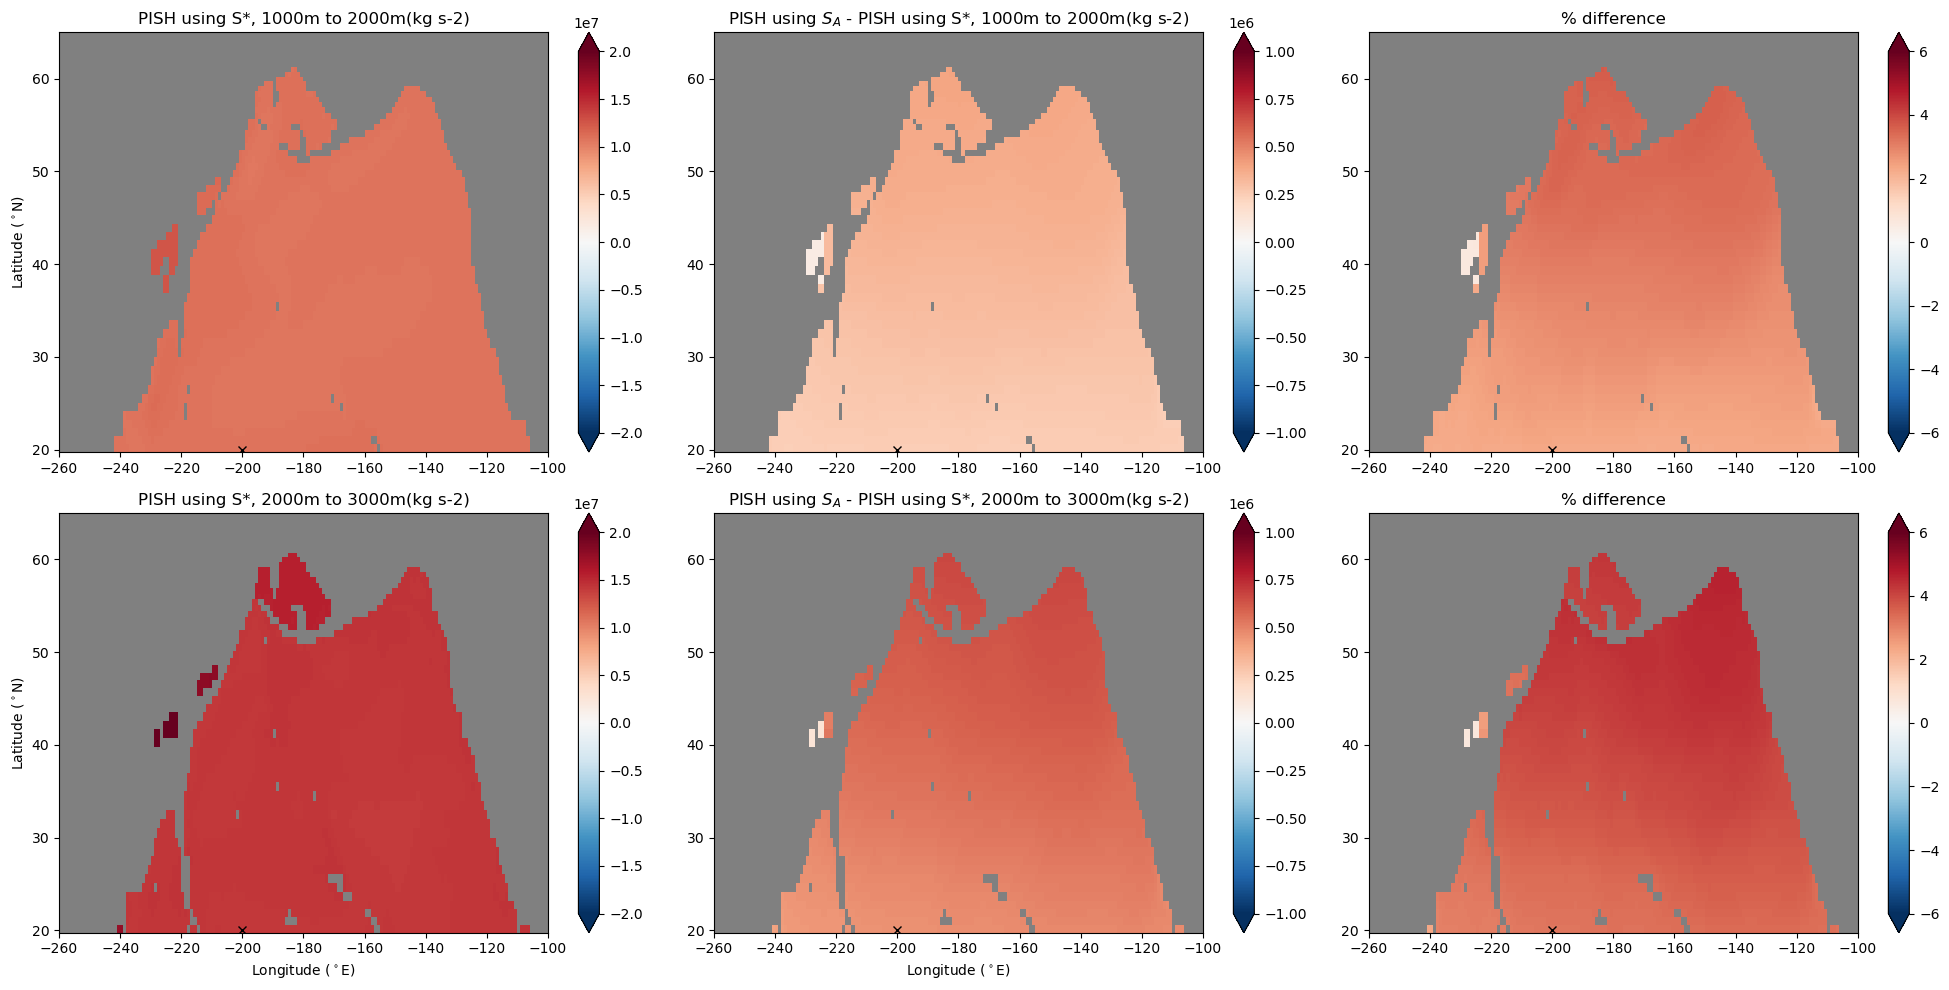

In [93]:
# Do some plotting:
depths = [[1000.,2000.],[2000.,3000.]]#,[3000.,4000.]]
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

# varss = [Psi_Sstar,Psi_SA]
# label = 'Geostrophic $\Psi$\''
# tclims = [100.,250.,400.]
# aclims = [0.5,2.5,8.]

varss = [PISH_Sstar,PISH_SA]
tclims = [2e7,2e7]
aclims = [1e6,1e6]
pc_dif = 6
# tclims = [1e6,1e6]
# aclims = [2e5,2e5]
# pc_dif = 100
label = 'PISH'
unit = 'kg s-2'

for i, depthsb in enumerate(depths):
    depth0, depth = depthsb
    (varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0)).plot(ax=axes[i][0],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-tclims[i],vmax=tclims[i])
    axes[i][0].set_title(label + ' using S*, %04dm to %04dm' % (depth0,depth) + '(' + unit + ')')
    axes[i][0].plot([-200.],[20.],'xk')
    ((varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))-(varss[1].sel(st_ocean=depth)-varss[1].sel(st_ocean=depth0))).plot(ax=axes[i][1],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-aclims[i],vmax=aclims[i])
    axes[i][1].set_title(label + ' using $S_A$ - ' + label + ' using S*, %04dm to %04dm' % (depth0,depth) + '(' + unit + ')')
    axes[i][1].plot([-200.],[20.],'xk')
    (((varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))-(varss[1].sel(st_ocean=depth)-varss[1].sel(st_ocean=depth0)))/(varss[0].sel(st_ocean=depth)-varss[0].sel(st_ocean=depth0))*100).plot(ax=axes[i][2],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-pc_dif,vmax=pc_dif)
    axes[i][2].set_title('% difference')
    axes[i][2].plot([-200.],[20.],'xk')

axs = axes.reshape(-1)
for ax in axs:
    ax.set_facecolor([0.5, 0.5, 0.5])
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[-1][0].set_xlabel('Longitude ($^\circ$E)')
axes[-1][1].set_xlabel('Longitude ($^\circ$E)')
for ax in [axes[0][0],axes[1][0]]:
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.tight_layout()
plt.savefig('McDougall_SAvsStar_PISH_' + sim + '_1000to2000_and_2000to3000.png',bbox_inches='tight')

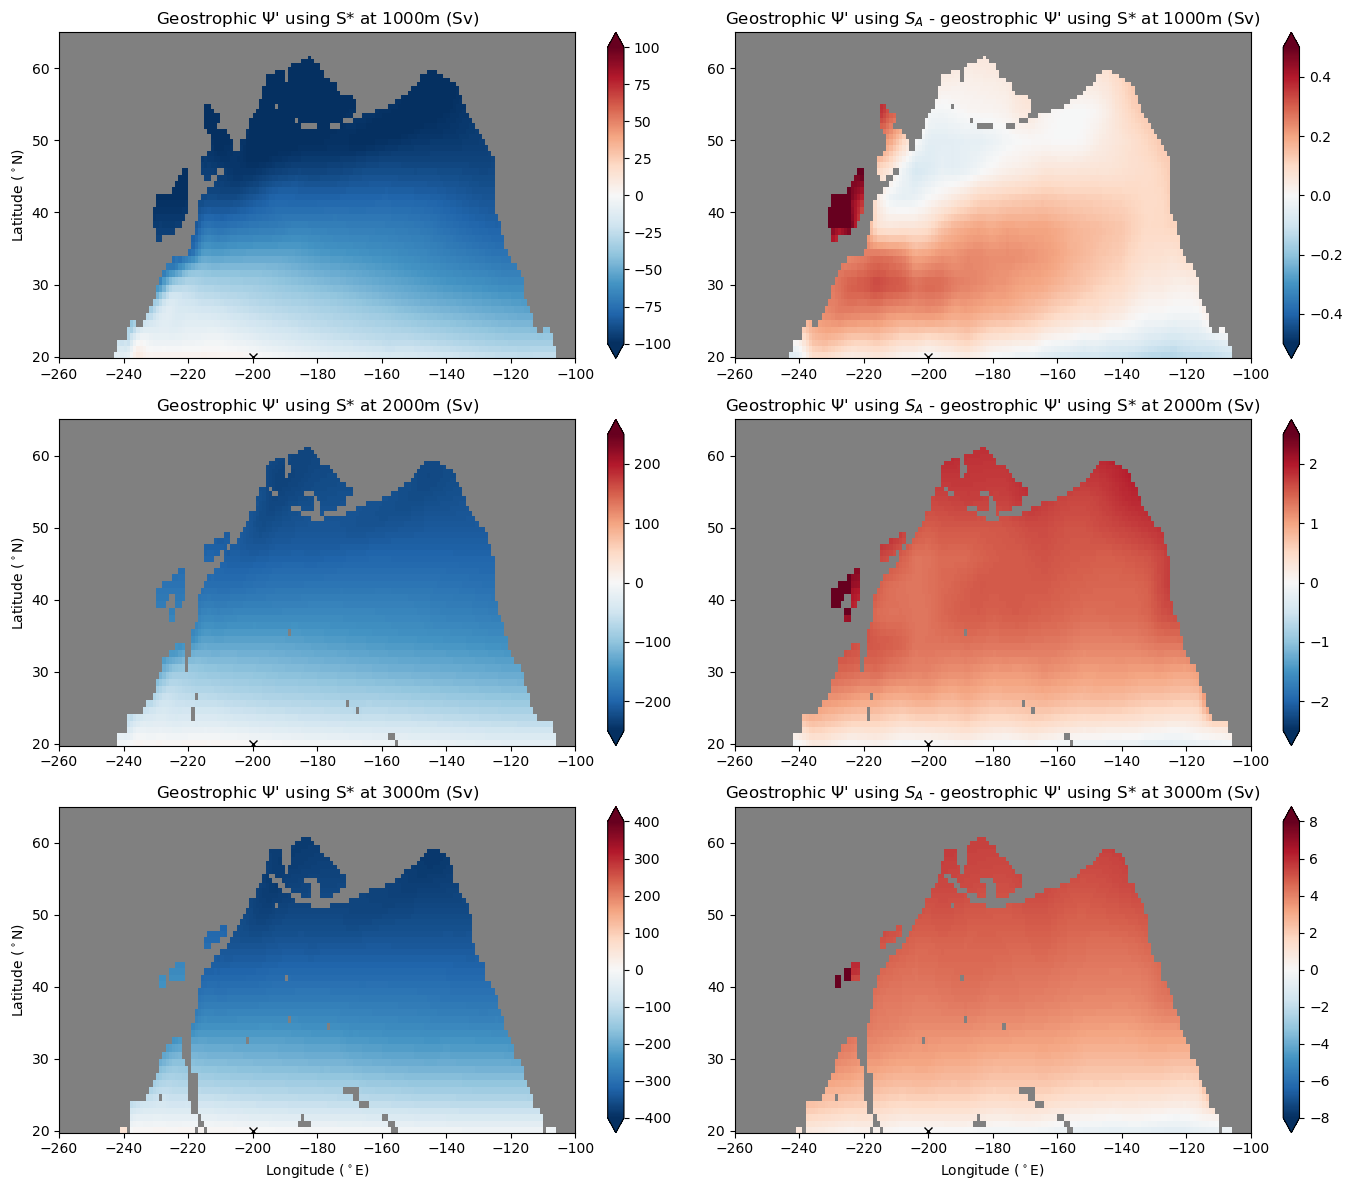

In [17]:
# Do some plotting:
depth0 = 
depths = [1000., 2000., 3000.]
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(14,12))

tclims = [100.,250.,400.]
aclims = [0.5,2.5,8.]
for i, depth in enumerate(depths):
    Psi_Sstar.sel(st_ocean=depth).plot(ax=axes[i][0],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-tclims[i],vmax=tclims[i])
    axes[i][0].set_title('Geostrophic $\Psi$\' using S* at %04dm (Sv)' % depth)
    axes[i][0].plot([-200.],[20.],'xk')
    (Psi_SA-Psi_Sstar).sel(st_ocean=depth).plot(ax=axes[i][1],extend='both',cmap='RdBu_r',cbar_kwargs={'label':''},vmin=-aclims[i],vmax=aclims[i])
    axes[i][1].set_title('Geostrophic $\Psi$\' using $S_A$ - geostrophic $\Psi$\' using S* at %04dm (Sv)' % depth)
    axes[i][1].plot([-200.],[20.],'xk')

axs = axes.reshape(-1)
for ax in axs:
    ax.set_facecolor([0.5, 0.5, 0.5])
    ax.set_xlabel('')
    ax.set_ylabel('')

axes[-1][0].set_xlabel('Longitude ($^\circ$E)')
axes[-1][1].set_xlabel('Longitude ($^\circ$E)')
for ax in [axes[0][0],axes[1][0],axes[2][0]]:
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.tight_layout()
plt.savefig('McDougall_SAvsStar_GeostrophicPsi_' + sim + '_1000-2000-3000m.png',bbox_inches='tight')

## Compute geostrophic stremfunction as test:

In [36]:
# Compute and plot geostrophic streamfunction with respect to sea surface:
Psi = xr.zeros_like(ds.SA).copy(deep=True)
Psi.data = gsw.geo_strf_dyn_height(ds.SA,ds.CT,ds.p,0.)